In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
from tqdm import tqdm
#from functions import *
sns.set_style('whitegrid')

In [6]:
commodities = {'ZN=F':'US_10_Year_T_Note','ZF=F':'US_5_Year_T_Note','ZT=F':'US_2_Year_T_Note',
               'GC=F':'Gold', 'SI=F':'Silver','PL=F':'Platinum','HG=F':'Copper','PA=F':'Palladium',
               'CL=F':'Crude_Oil','HO=F':'Heating_oil','NG=F':'Natural_Gas','RB=F':'RBOB_Gasoline','BZ=F':'Brent_Crude_Oil',
               'CC=F':'Cocoa','KC=F':'Coffee','CT=F':'Cotton'}

INITIAL_AMT_INVESTED = 10000
NUM_OF_SIMULATIONS = 1000
start_date='2023-01-01'
end_date='2023-12-31'

In [3]:
## A FUNCTION TO RETRIEVE INFORMATION FOR A GIVEN LIST OF STOCKS

def fetch_data(stock_list, start_date, end_date, div=True):
    
    """Returns stock_price_df, stock_dividend_df"""
    
    if type(stock_list)!=list:
        stock_list = [stock_list]
    
    for i in range(len(stock_list)):
        stock_list[i] = stock_list[i].upper()

    stock_price = {}
    stock_dividend = {}
    for i in tqdm(range(len(stock_list))):
        ticker = yf.Ticker(stock_list[i])
        stock_data = ticker.history(start=start_date, end=end_date)
        stock_price[stock_list[i]] = stock_data['Close']
        stock_dividend[stock_list[i]] = stock_data['Dividends']
        
    return pd.DataFrame(stock_price), pd.DataFrame(stock_dividend)

In [4]:
comm_prices, temp = fetch_data(list(commodities.keys()), start_date=start_date, end_date=end_date)
comm_prices = comm_prices.rename(columns=commodities)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.92it/s]


In [5]:
## CALCULATING LOG RETURNS
comm_log_returns = np.log(comm_prices/comm_prices.shift(1))
comm_log_returns = comm_log_returns[1:]

In [7]:
portfolio_weights = []
portfolio_returns = []
portfolio_risks = []
NUM_TRADING_DAYS = len(comm_prices)


## MONTE CARLO SIMULATION

for i in tqdm(range(NUM_OF_SIMULATIONS)):
    
    ## STEP-I: generating random weights
    w = np.random.rand(comm_log_returns.shape[1])
    w = np.expand_dims(w, axis=0)
    w = w/np.sum(w)
    portfolio_weights.append(w)
    
    ## STEP-II: calculating returns using average annual returns
    p_returns = (comm_log_returns.mean() @ w.T*NUM_TRADING_DAYS)[0]
    portfolio_returns.append(p_returns)
    
    ## STEP-III: calculating risks
    p_risks = np.sqrt(w @ comm_log_returns.cov()*NUM_TRADING_DAYS @ w.T)[0][0]
    portfolio_risks.append(p_risks)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1098.17it/s]


In [8]:
portfolio_weights = np.array(portfolio_weights)
portfolio_returns = np.array(portfolio_returns)
portfolio_risks = np.array(portfolio_risks)

## CALCULATING SHARPE RATIO

# taking IR of government issued 10-year bonds as risk-free rate
risk_free_rate = 0.07

sharpe_ratios = (portfolio_returns - risk_free_rate) / portfolio_risks

In [9]:
## OPTIMIZED WEIGHTS

index = np.argmax(sharpe_ratios)
optimized_weights = portfolio_weights[index].flatten()

num_of_shares = INITIAL_AMT_INVESTED*optimized_weights/comm_prices.iloc[0,:]
num_of_shares = np.expand_dims(num_of_shares, axis=0)

In [11]:
## CALCULATING PORTFOLIO VALUE
portfolio_value = np.sum(num_of_shares*np.array(comm_prices), axis=1)

## PORTFOLIO DATAFRAME
df_portfolio = num_of_shares*comm_prices
df_portfolio['PORTFOLIO_VALUE'] = portfolio_value

<Axes: xlabel='Date'>

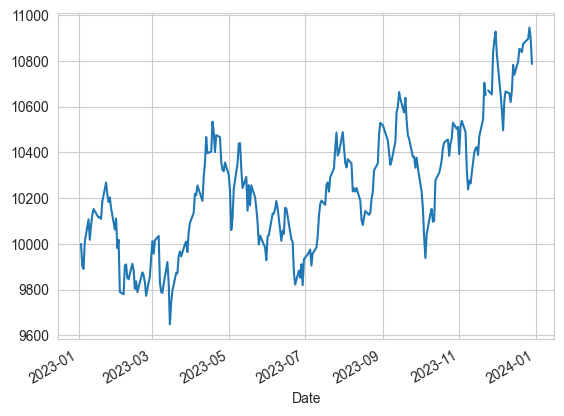

In [12]:
df_portfolio['PORTFOLIO_VALUE'].plot()

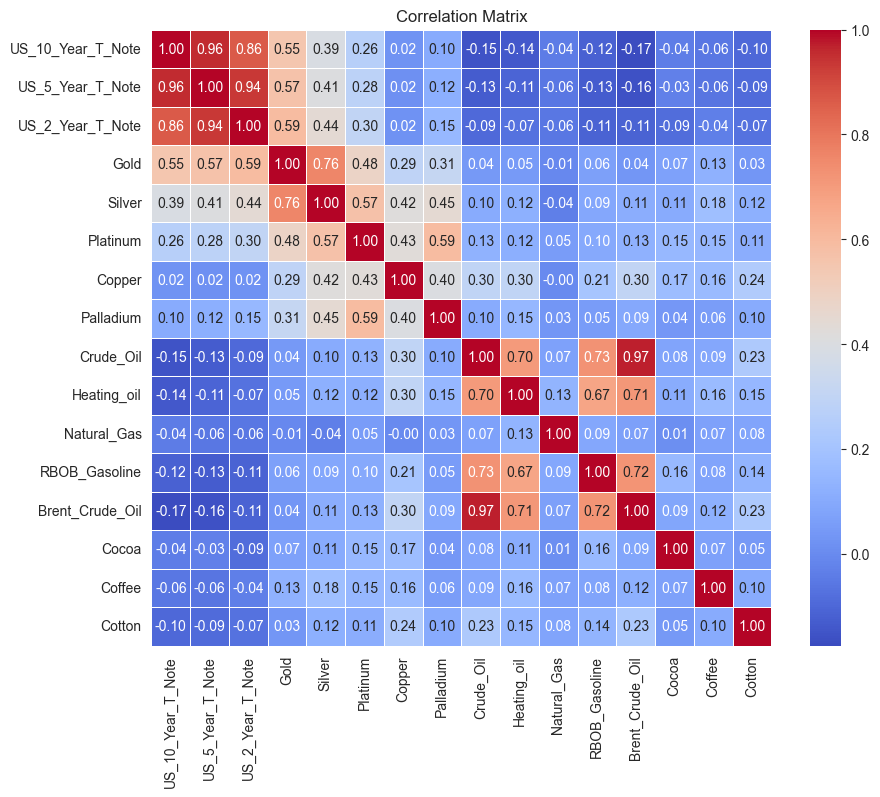

In [11]:
## CORRELATION MATRIX

correlation_matrix = comm_log_returns.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()